# This project
Clean up the project such that only the MHI (3-channel duplicate) with CNN architectures.

## Import Dependencies

In [29]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [30]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random
import wandb

from typing import Tuple
from collections import Counter
import albumentations as A
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf

In [31]:
#Fixed parameters throughout the project 
class CONFIG:
    ROOT_DIRECTORY = "asl_dataset_word/WASL_data"
    #dataset_folder = "bsl_dataset/manual-script" - bsl
    JSON_FILE = "WLASL_v0.3.json"
    NSLT_FILE = "nslt_100.json"
    VIDEO_FOLDER = "videos"

    #mean=[0.485, 0.456, 0.406]
    #std=[0.229, 0.224, 0.225]
    mean = [0, 0, 0]
    std = [1,1,1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.9
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.1
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    #PC: data limit to 100/50 for now
    DATA_LIMIT = 100
    FRAME_SIZE = 30
    
    
    BATCH_SIZE = 8
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"

# Motion History Image Method - CNN Shape
Motion History Image (MHI) represent motion in sequence frames as a single image. The intensity of each pixel in the MHI corresponds to the recency of motion at that location - brighter the pixel, more recent the location.

Algorithm generates MHI that captures the temporal aspects of motion by decaying older movements and highlight new ones - using further analysis like action recognition on 2DCNN.

In [3]:
#USE THIS - decay rate of 0.09
def update_mhi(prev_frame, current_frame, mhi, decay=0.09):
    """
    Update the motion history image (MHI) to retain motion across the entire video,
    adapted for a 3-channel (color) MHI.
    
    - prev_frame: The previous frame in the video (BGR).
    - current_frame: The current frame in the video (BGR).
    - mhi: The current state of the MHI, a 3-channel image.
    - decay: The rate at which previous motion history fades.
    """
    # Compute the absolute difference between the current and the previous frame
    frame_diff = cv2.absdiff(current_frame, prev_frame)
    
    # Convert the frame difference to grayscale and threshold it
    gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    _, motion_mask = cv2.threshold(gray_diff, 25, 1, cv2.THRESH_BINARY)
    
    # Convert the single-channel motion mask to a 3-channel mask
    motion_mask_3ch = cv2.merge([motion_mask, motion_mask, motion_mask])
    
    # Update the MHI: New motion is added with a value of 1, and existing motion history decays
    # Ensure that both mhi and motion_mask_3ch are floats for correct operation
    mhi = (mhi * (1 - decay)) + np.float32(motion_mask_3ch)
    
    # Ensure MHI values are capped at 1
    mhi = np.clip(mhi, 0, 1)
    
    return mhi

In [4]:
# Capture video from input video
cap = cv2.VideoCapture('bsl_dataset/manual-script/sorry/sorry_28.mp4')

# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Failed to read video")
    cap.release()
    cv2.destroyAllWindows()
    exit()

# Initialize MHI with 3 channels to keep color information
mhi = np.zeros((*prev_frame.shape[:2], 3), dtype=np.float32)

# List to store MHIs
mhis = []

# Process video to generate MHI
while True:
    ret, current_frame = cap.read()
    if not ret:
        break  # End of video
    
    # Update MHI
    mhi = update_mhi(prev_frame, current_frame, mhi)
    
    # Prepare for next iteration
    prev_frame = current_frame.copy()

    # Optionally, visualize the MHI
    normalized_mhi = np.uint8(np.clip((mhi / mhi.max()) * 255, 0, 255))
    cv2.imshow("MHI", normalized_mhi)
    
    resized_mhi = cv2.resize(normalized_mhi, (224, 224))

    # Store the MHI for this frame
    mhis.append(resized_mhi.copy())

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Save the last MHI image to a file
output_path = 'mhi_image28_alt_0.09.png'  # Adjust the output path as needed
cv2.imwrite(output_path, resized_mhi)

# Clean up
cap.release()
cv2.destroyAllWindows()

# NOTE: Further processing to fit MHIs into MobileNetV2 would follow here,
# including resizing and normalization as needed for your application.

In [5]:
output_path
mhi_array = np.array(mhi)
normalized_mhi_array = np.array(resized_mhi)
print("Shape of the mhi_array:", mhi_array.shape)
#print("Shape of stacked_mhi:", stacked_mhis.shape)
print("Shape of normalized:", resized_mhi.shape)

Shape of the mhi_array: (720, 1280, 3)
Shape of normalized: (224, 224, 3)


## Motion History Image - 3 channel decay method (Abandon)
Idea: Instead of duplicating the MHI into 3 channel for RBG into mobile net, set different decay rate and log it into the shape.
Then the input should be fed into MobileNetv2.

This is still in progress - might need to expand this experiment later on.

In [6]:
#changed approach, each mhi is defined using this method then combined at the end with a wrapper function
def update_mhi_single_chan(prev_frame, current_frame, mhi, decay):
    # Compute the absolute difference between the current and the previous frame
    frame_diff = cv2.absdiff(current_frame, prev_frame)
    
    # Convert the frame difference to grayscale and threshold it
    gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    _, motion_mask = cv2.threshold(gray_diff, 25, 1, cv2.THRESH_BINARY)
    
    # Convert the single-channel motion mask to a 3-channel mask
    #motion_mask_3ch = cv2.merge([motion_mask, motion_mask, motion_mask])
    
    # Update the MHI: New motion is added with a value of 1, and existing motion history decays
    # Ensure that both mhi and motion_mask_3ch are floats for correct operation
    mhi = (mhi * (1 - decay)) + np.float32(motion_mask)
    
    # Ensure MHI values are capped at 1
    mhi = np.clip(mhi, 0, 1)
    
    return mhi

def mhi_3channel(prev_frame, current_frame, mhi_log):
    mhi_1, mhi_2, mhi_3 = cv2.split(mhi_log) 
    mhi_1 = update_mhi_single_chan(prev_frame, current_frame, mhi_1, 0.0009)
    mhi_2 = update_mhi_single_chan(prev_frame, current_frame, mhi_2, 0.009)
    mhi_3 = update_mhi_single_chan(prev_frame, current_frame, mhi_3, 0.9)
    
    mhi_3ch = cv2.merge([mhi_1, mhi_2, mhi_3])
    mhi_3ch_final = np.clip(mhi_3ch, 0, 1)
    
    return mhi_3ch_final
    

In [7]:
#USE THIS
# Capture video from input video
cap = cv2.VideoCapture('bsl_dataset/manual-script/sorry/sorry_28.mp4')

# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Failed to read video")
    cap.release()
    cv2.destroyAllWindows()
    exit()

# Initialize MHI with 3 channels to keep color information
mhi = np.zeros((*prev_frame.shape[:2], 3), dtype=np.float32)

# List to store MHIs
mhis = []

# Process video to generate MHI
while True:
    ret, current_frame = cap.read()
    if not ret:
        break  # End of video
    
    # Update MHI
    mhi = mhi_3channel(prev_frame, current_frame, mhi)
    
    # Prepare for next iteration
    prev_frame = current_frame.copy()

    # Optionally, visualize the MHI
    normalized_mhi = np.uint8(np.clip((mhi / mhi.max()) * 255, 0, 255))
    cv2.imshow("MHI_3channel", normalized_mhi)
    
    resized_mhi = cv2.resize(normalized_mhi, (224, 224))

    # Store the MHI for this frame
    mhis.append(resized_mhi.copy())

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Save the last MHI image to a file
output_path = 'mhi_image_3decay.png'  # Adjust the output path as needed
cv2.imwrite(output_path, resized_mhi)
#cv2.imshow(resized_mhi)

# Clean up
cap.release()
cv2.destroyAllWindows()

# NOTE: Further processing to fit MHIs into MobileNetV2 would follow here,
# including resizing and normalization as needed for your application.

Shape of the mhi_array: (720, 1280, 3)
Shape of normalized: (224, 224, 3)


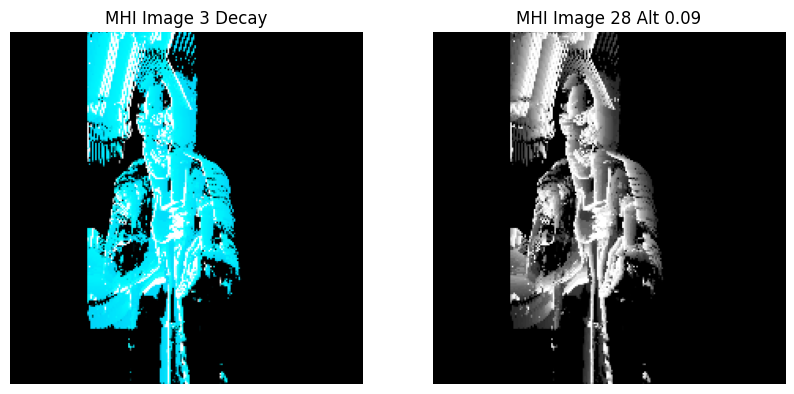

In [8]:
#check the output shape of the combined mhi 
mhi_array = np.array(mhi)
normalized_mhi_array = np.array(resized_mhi)
print("Shape of the mhi_array:", mhi_array.shape)
#print("Shape of stacked_mhi:", stacked_mhis.shape)
print("Shape of normalized:", resized_mhi.shape)

#optional plot the different image - side by side comparison.
from PIL import Image


# Load the images
img1 = Image.open('mhi_image_3decay.png')
img2 = Image.open('mhi_image28_alt_0.09.png')

# Create a figure to display the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].set_title('MHI Image 3 Decay')
axes[0].axis('off')  # Turn off axis numbers and ticks

axes[1].imshow(img2)
axes[1].set_title('MHI Image 28 Alt 0.09')
axes[1].axis('off')  # Turn off axis numbers and ticks

plt.show() #show that there is not much difference between the image algorithm methods.

# Setup Folders for Collection

In [9]:
#Defining Data
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MHI_Data') 

# Actions that we try to detect
actions = np.array(['thanks', 'sorry'])
#no_sequences = 100


# Collect Extracted Matrix Values for Training

### Data Augmentation
To increase dataset - apply image transformation to each frame of the video in order to do so.
Code tested on Kaggle and ported to local jupyter notebook - test run ML and ready to run on cloud.

In [13]:
from math import ceil, sqrt

def visualize_video(frames, save_path=None, mult=2, show=True):

    # load the frame 
    # frames = get_video(found_ids[0])

    # calculate the grid
    image_cnt = frames.shape[0]
    rounded_cnt = ceil(sqrt(image_cnt))

    # calculate the width/height ratio
    ratio = frames.shape[1] / frames.shape[2]

    # create grid of arrays
    fig, axs = plt.subplots(rounded_cnt, rounded_cnt, figsize=( rounded_cnt*mult, ratio * rounded_cnt*mult))
    axs_flat = axs.flatten()

    # Loop through images and display each
    for i in range(rounded_cnt * rounded_cnt):
        if i < len(frames):
            axs_flat[i].imshow(frames[i])
        axs_flat[i].axis('off')  # Turn off axis
        axs_flat[i].set_title(i)

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')        
    
    if show:
        plt.show()
    else:
        plt.close()

In [14]:
from sklearn.model_selection import train_test_split
from math import ceil

class SignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, max_start : int, max_end) -> None:
        # setup the paths
        video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
        dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

        # load the filepaths for videos
        self.video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

        # load the dataset config json
        self.config_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
            self.config_json = json.load(f)

        # load the dataset json
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f)
        
        self.videos_paths = []
        self.paths_not_found = []
        self.labels = []
        self.start_frames = []
        self.end_frames = []
       
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f) 

        for el in tqdm(self.dataset_json.items()):
            video_id, properties = el[0], el[1]
            path = os.path.join(video_path, video_id + ".mp4")
            
            if not os.path.exists(path):
                self.paths_not_found.append(path)
                continue

            subset = properties["subset"]
            label, start, end = properties["action"]
            
            if start > max_start:
                continue
                
            if end > max_end:
                continue
            
            self.videos_paths.append(path)
            self.labels.append(label)
            self.start_frames.append(start)
            self.end_frames.append(end)
    
        self.videos_paths = np.array(self.video_paths)
        self.paths_not_found = np.array(self.paths_not_found)
        self.labels = np.array(self.labels)
        self.start_frames = np.array(self.start_frames)
        self.end_frames = np.array(self.end_frames)

        self.unique_labels = np.unique(self.labels)
        
    
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return traj
    
    def __len__(self):
        return len(self.videos_paths)

    def __getitem__(self, idx):
        path, label = self.videos_paths[idx], self.labels[idx]
        trajectory = SignRecognitionDataset.get_video(path)
        
        return self.preprocess_trajectory(trajectory), label

    def permutate(self):
        l = len(self.videos_paths)
        mask = np.arange(l)
        np.random.shuffle(mask)
        
        self.videos_paths = np.array(self.videos_paths)[mask]
        self.labels = np.array(self.labels)[mask]
        self.start_frames = np.array(self.start_frames)[mask]
        self.end_frames = np.array(self.end_frames)[mask]
        
    def sort_by_size(self):
        c = Counter(self.labels)
        _mask = sorted([ (10000 * c[l] + l, i) for i, l in enumerate(self.labels)])[::-1]
        mask_by_size = np.array([el[1] for el in _mask])

        self.video_paths        = np.array(self.video_paths)[mask_by_size]
        self.labels             = np.array(self.labels)[mask_by_size]
        self.start_frames       = np.array(self.start_frames)[mask_by_size]
        self.end_frames         = np.array(self.end_frames)[mask_by_size]

    def crop_video(self, trajectory : np.array) -> np.array:
        cropped = trajectory
        
        if self.FRAME_SIZE != 0:
            frame_size = len(trajectory)
            start = 0 
            
            if frame_size > self.FRAME_SIZE:
                start = np.random.randint(0, frame_size - self.FRAME_SIZE)
            cropped = trajectory[start: (start + self.FRAME_SIZE)]
                    
            if len(cropped) < self.FRAME_SIZE:
                necessary = self.FRAME_SIZE - len(cropped)
                t, h, w, c = trajectory.shape
                cropped = np.concatenate([cropped, np.zeros((necessary, h, w, c))], axis= 0)
                
            return cropped
                        
        return trajectory
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)
        
class SignRecognitionDatasetMHI(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, 
                 per_image_transform=None,
                 after_MHI_transform=None,
                 scaled_resolution : Tuple[int]= (224, 224),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 decay : float = 0.7,
                 threshold_method : str = "regular",
                 threshold_val : float = 25/255.,
                 by_size=True,
                 batch_size=CONFIG.BATCH_SIZE,
                 train_val_split:float=CONFIG.PORTION_OF_DATA_FOR_TRAINING,
                 split:str="train") -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.per_image_transform = per_image_transform
        self.after_MHI_transform = after_MHI_transform
        self.FRAME_SIZE = frame_size
        self.decay = decay
        self.threshold_method = threshold_method
        self.threshold_val = threshold_val
        self.batch_size = batch_size
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
        self.sort_by_size()
        
        if self.DATA_LIMIT > 0:
            self.video_paths        = self.video_paths[:self.DATA_LIMIT]
            self.labels             = self.labels[:self.DATA_LIMIT]
            self.start_frames       = self.start_frames[:self.DATA_LIMIT]
            self.end_frames         = self.end_frames[:self.DATA_LIMIT]
        
        
        self.label_2_id = { key : i for i, key in enumerate(np.unique(self.labels))}
        if data_limit < 0:
            train_ds_x, val_ds_x = train_test_split(self.videos_paths, train_size=train_val_split, random_state=42)
            train_ds_y, val_ds_y = train_test_split(self.labels, train_size=train_val_split, random_state=42)
            
        else:
            self.unique_labels = np.unique(self.labels[:data_limit])
            self.label_2_id = { key : i for i, key in enumerate(np.unique(self.labels))}
            
            train_ds_x, val_ds_x = train_test_split(self.videos_paths[:data_limit], train_size=train_val_split, random_state=42)
            train_ds_y, val_ds_y = train_test_split(self.labels[:data_limit], train_size=train_val_split, random_state=42)
                                    
        if split.lower() == "train":
            self.videos_paths = train_ds_x
            self.labels = train_ds_y
            
        elif split.lower() == "val":
            self.videos_paths = val_ds_x
            self.labels = val_ds_y
        
        else: 
            raise Exception("")
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)
        
    def __len__(self):
        return int(ceil(len(self.videos_paths) / self.batch_size))

    def get_MHI_from_trajectory (self, traj : np.ndarray) -> np.ndarray:
        # timeframe, Width, height, channels
        ts, w, h, c = traj.shape
        
        mhi = np.zeros((w, h))
                
        for i in range(1, ts):
            frame_diff = np.abs(traj[i] - traj[i-1])
            gray_diff = np.mean(frame_diff, axis=2)
            
            _, binary_diff = cv2.threshold(gray_diff, self.threshold_val, 1.0, cv2.THRESH_BINARY)
    
    
            mhi = mhi * (1.0 - self.decay) + binary_diff

        mhi = mhi.reshape(mhi.shape[0], mhi.shape[1], 1)
        return np.concatenate([mhi,mhi,mhi], axis=2)

        

    def get_single(self, idx):
        trajectory = SignRecognitionDataset.get_video(self.videos_paths[idx])  
        trajectory, label = self.crop_video(self.preprocess_trajectory(trajectory)), self.labels[idx]

        if self.per_image_transform is not None:            
            frames = {self.keywords[i] : frame for i, frame in enumerate(trajectory)}
            processing = self.per_image_transform(**frames)       

            trajectory = np.array([processing[kw] for kw in self.keywords])    

        return self.get_MHI_from_trajectory(trajectory), label

    def __getitem__(self, idx):
        
        X, Y = [], []
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.videos_paths))
        
        for i in range(low, high):
            x, y = self.get_single(i)
            X.append(x)
            #
            onehotencoded = np.zeros(len(self.unique_labels))
            onehotencoded[self.label_2_id[y]] = 1.0
            Y.append(onehotencoded)
        
        return np.array(X), np.array(Y)

In [15]:
transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
                           scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ],
    additional_targets={str(i) : "image" for i in range(CONFIG.FRAME_SIZE)}
)

import matplotlib.pyplot as plt 
#ds = SignRecognitionDatasetMHI(1, 150, per_image_transform=transform, decay=0.009)
train_ds = SignRecognitionDatasetMHI(1, 150, per_image_transform=transform, decay=0.09, split="train")
val_ds = SignRecognitionDatasetMHI(1, 150, per_image_transform=transform, decay=0.09, split="val")

100%|██████████| 2038/2038 [00:04<00:00, 496.64it/s]


In [16]:
#Test the shape of validation and train dataset
print(train_ds[0][0].shape)
print(train_ds[0][1].shape)

(8, 224, 224, 3)
(8, 7)


In [17]:
print(len(train_ds), len(val_ds))

10 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


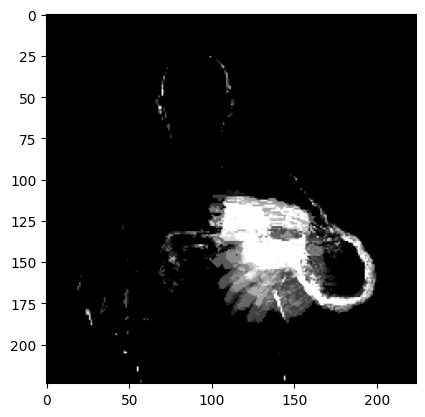

In [18]:
#show an MHi taken from train dataset.
plt.imshow(train_ds[3][0][5], cmap='gray')

In [ ]:
#code that measures the time taken to iterate through the train dataset once.
import time 

ls = [] 

start_t = time.time()
for x,_,y in tqdm(train_ds):
    ls.append(y)

print(f"iteration through dataset took :  {round(time.time() - start_t, CONFIG.ROUND_DIGIT)} s")

# Preprocess Data, Create Labels and Features

#### Based on Data Augmentation - Prepare for CNN ML Training

In [32]:
#import required libraries
import tensorflow as tf
import wandb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D , Flatten, BatchNormalization
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
#from tensorflow.keras.callbacks import TensorBoard


In [33]:
#Fixed learning rate: adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003) #0.001 can be changed.

#learning rate decay for Adam
initial_learning_rate = 0.0003  # Starting learning rate
decay_steps = 100000           # After how many steps to apply decay
decay_rate = 0.96              # Decay rate
staircase = True               # Apply decay in a staircase fashion

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=staircase
)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  # Use the learning rate schedule here

In [34]:

class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=50, epochs=100): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    """wandb.init(project=CONFIG.WANDB_RUN,
                     name=run_name,
                     notes="Model summary : \n" + str(model),
                     config={"max_lr" : max_lr, 
                             "min_lr" : 5e-5, 
                             "scheduler" : "cosineAnnealer", 
                             "epochs" : epochs, 
                             "T_max" : T_max, 
                             "train_size" : len(train_dataset_parquet.dataset),
                             "val_size" : len(val_dataset_parquet.dataset),
                             "unique_classes" : len(train_dataset_parquet.unique_labels), 
                             "video_length" : CONFIG.VIDEO_LENGTH,
                             "features" : mediapipe_features
                             }) """
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = 8, callbacks=[checkpoint])
    #wandb.finish()
    
    return history

# Build and Train CNN Neural Network
Taking from pre-trained image CNN
Create base model from pre-trained model: MobileNet V3Small
Step 1: Create Base Model from MobileNet V2 model developed at Google.
Step 2: Freeze layers
Step 3: Train new layers on dataset
Step 4: Improve model via fine-tuning

### MobileNetV3Small

In [ ]:
#create logs to view learning in real time using TensorBoard
log_dir = os.path.join('Logs_MHI_ASL_MobileNetV3')
#tb_callback = TensorBoard(log_dir=log_dir)

tb_callback = [TensorBoard(log_dir=log_dir,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]

#code previously
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#Train the model - MobileNetV3Small as pretrained model. Tensorboard callback.
model.fit(X_train, y_train, epochs=1000, validation_data = (X_dev, y_dev), batch_size = 8, callbacks=[tb_callback])
#save the model (for future load and training purposes)
model.save('MobileNetV3Small_first.keras')

In [36]:
#FD_SHAPE = (444, 444, 3)
#MobileNetV3 uses input shape of (224, 224, 3)
MHI_SHAPE = (224,224,3)
#reshaped_data = data.reshape(-1, 480, 640, 1)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Do not freeze the convolutional base
base_model.trainable = True
#get the model summary
#base_model.summary() 

In [37]:
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, filepath=os.path.join("models", "MHI_MobileNetV3Small.keras"))

Epoch 1/100


c:\Users\mered\anaconda3\envs\frame_diff\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - categorical_accuracy: 0.1283 - loss: 16.4972 - val_categorical_accuracy: 0.1500 - val_loss: 3.1036
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 930ms/step - categorical_accuracy: 0.1066 - loss: 9.9040 - val_categorical_accuracy: 0.2000 - val_loss: 2.9794
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 808ms/step - categorical_accuracy: 0.1021 - loss: 8.1599 - val_categorical_accuracy: 0.1000 - val_loss: 3.1431
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 847ms/step - categorical_accuracy: 0.1286 - loss: 6.8852 - val_categorical_accuracy: 0.3000 - val_loss: 3.0268
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - categorical_accuracy: 0.1313 - loss: 6.2370 - val_categorical_accuracy: 0.2500 - val_loss: 2.9904
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 848ms/step - categorical_accuracy: 0.2127 - loss: 5.3723 - val_categorical_accuracy: 0.2500 - val_loss: 2.7862
Epoch 7/100


KeyboardInterrupt: 

## MHI Image + EfficientNetB0
29 Size MB (compared to other EfficientNetBVersion). 

MobileNet Smallest -> NASNetMobile -> EfficientNetB0

In [38]:
MHI_SHAPE = (224,224,3)

# get the base model, exclude final dense layers - we will modify/output this
base_model_eff = tf.keras.applications.EfficientNetB0(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')

#do not freeze base model layers, outputs model summary
base_model_eff.trainable = True
base_model_eff.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [39]:
model_eff = Sequential()
model_eff.add(base_model_eff)
#output layer have the same units as 'labels'
model_eff.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model_eff, filepath=os.path.join("models", "MHI_EfficientNetB0.keras"))

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - categorical_accuracy: 0.0952 - loss: 6.8757 - val_categorical_accuracy: 0.2000 - val_loss: 5.9831
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - categorical_accuracy: 0.1593 - loss: 5.2377 - val_categorical_accuracy: 0.2000 - val_loss: 8.0413
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - categorical_accuracy: 0.2452 - loss: 2.9892 - val_categorical_accuracy: 0.2000 - val_loss: 8.1164
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - categorical_accuracy: 0.3143 - loss: 3.0812 - val_categorical_accuracy: 0.2000 - val_loss: 6.7077
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - categorical_accuracy: 0.3203 - loss: 2.6192 - val_categorical_accuracy: 0.2000 - val_loss: 5.6705
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - categorical_accuracy: 0.3266 - loss: 2.5597 - val_categorical_accuracy: 0.2000 - val_loss: 4.6064
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.5944 - loss: 1.24

KeyboardInterrupt: 

## Simple CNN Architecture LeNet

In [40]:
MHI_SHAPE = (224,224,3)
model_leNet = Sequential()
#Block 1
model_leNet.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=MHI_SHAPE))
model_leNet.add(BatchNormalization())
model_leNet.add(Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

#Block 2
model_leNet.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

#Block 3
model_leNet.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

#Block 4
model_leNet.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_leNet.add(BatchNormalization())
model_leNet.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

model_leNet.add(Flatten())
model_leNet.add(Dense(128, activation='relu'))
#model.add(Dense(units=actions.shape[0], activation='softmax'))
model_leNet.add(Dense(len(train_ds.unique_labels), activation='softmax'))

#model.summary()

c:\Users\mered\anaconda3\envs\frame_diff\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [41]:
keras_train(model_leNet, filepath=os.path.join("models", "MHI_LeNet.keras"))

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - categorical_accuracy: 0.2220 - loss: 2.7964 - val_categorical_accuracy: 0.2000 - val_loss: 1.9396
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.2440 - loss: 2.5191 - val_categorical_accuracy: 0.2000 - val_loss: 1.9445
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.2007 - loss: 2.2202 - val_categorical_accuracy: 0.1500 - val_loss: 1.9617
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.3617 - loss: 1.6691 - val_categorical_accuracy: 0.1500 - val_loss: 1.9870
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.3457 - loss: 1.9511 - val_categorical_accuracy: 0.1500 - val_loss: 2.0433
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.4442 - loss: 1.7732 - val_categorical_accuracy: 0.1500 - val_loss: 2.0100
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.5517 - loss: 1.43

KeyboardInterrupt: 

# Test Values using Confusion Matrix
Note: to be implemented.